In [33]:
import sys
sys.path.append("..")
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential, plotRotcurve
from galpy.actionAngle import estimateDeltaStaeckel, actionAngleStaeckel
from galpy.actionAngle import UnboundError

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import numpy as np
from scipy import stats
from IPython.display import Image, display
from astropy import units as u
import corner

import datetime
import random

from decomposition import *
import copy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle
from matplotlib import animation
from matplotlib.colors import LogNorm
from matplotlib import rcParams

import datetime
%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'

cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:

# Simulation relevant stuff
machine = 'mac'
#machine = 'magny'
machine = 'virgo'

if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
    


In [13]:
snapnr = 127
snapnr, R0_kpc, v0_tot_kms, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc, v0_MND_kms, v0_HB_kms, v0_NFWH_kms = np.loadtxt(filedir + 'potential/potential_params_dec18/pot_snap_{}'.format(snapnr))

In [8]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]



In [59]:
_REFR0_kpc = R0_kpc
n_NFWH = v0_NFWH_kms**2 / v0_tot_kms**2
n_HB   = v0_HB_kms**2   / v0_tot_kms**2
n_MND  = v0_MND_kms**2  / v0_tot_kms**2

pot = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc)

In [28]:
def circvel_data(R_circ_stars_kpc, v_phi_circ_stars, Galrad, N = 25):
    indisk = R_circ_stars_kpc < Galrad
    #R_circ_stars_kpc[i_r_circ_stars_in]
    v_mean_kms, R_bin_edges, binnum = stats.binned_statistic(R_circ_stars_kpc[indisk], np.abs(vphi_circ_stars_kms[indisk]), statistic = 'mean', bins = N)
    v_std_kms, R_bin_edges_std, binnum_std = stats.binned_statistic(R_circ_stars_kpc[indisk], np.abs(vphi_circ_stars_kms[indisk]), statistic = np.std, bins = N)
    R_bins_kpc = R_bin_edges[:-1] + 1./2. * (R_bin_edges[1:] - R_bin_edges[:-1])
    return(v_mean_kms, v_std_kms, R_bins_kpc)


In [ ]:
snapnr = 127
level = 4
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
  
    print("snapnr  : {0}".format(snapnr))
    print(datetime.datetime.now().time())
    try:
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
        haloid=0, galradfac=0.1, verbose=True)    
    except KeyError:
        print('\n\n', snapnr, 'not read in.\n\n')
        continue

    try: 
        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
    except:
        continue


    Galrad = 1000. * s.galrad
    R0_kpc = 8.
    z0_kpc = 0.
    r0_kpc = R0_kpc
    dr_kpc = 0.5


    decompobj = decomposition(machine = 'virgo', snapnr = snapnr, use_masses = False, use_n = True, galpyinputfile = None, galpyinputdata = None, have_galpy_potential = False)
    ID_disk_circ, ID_spher_circ = decompobj._decomp(circ_val = 0.95, include_zmax = True, zmax = 0.005, plotter = False, savefig = False, Gcosmo = 43.0071)
    i_disk_circ= np.isin(s.id, ID_disk_circ)
    (R_circ_stars_kpc, phi_circ_stars_, z_circ_stars_kpc), (vR_circ_stars_kms, vphi_circ_stars_kms, vz_circ_stars_kms) = get_cylindrical_vectors(s, sf, i_disk_circ)

In [91]:
v_mean_data, v_std_data, R_bins_data = circvel_data(R_circ_stars_kpc, vphi_circ_stars_kms, Galrad, N = 30
                                                   )
MND = pot[0]
NFW = pot[1]
HB = pot[2]

vcirc_MND = vcirc(pot[0], R_bins_data/R0_kpc)* v0_tot_kms
vcirc_NFW = vcirc(pot[1], R_bins_data/R0_kpc)* v0_tot_kms
vcirc_HB = vcirc(pot[2], R_bins_data/R0_kpc) * v0_tot_kms
vcirc_tot = vcirc(pot, R_bins_data/R0_kpc) * v0_tot_kms

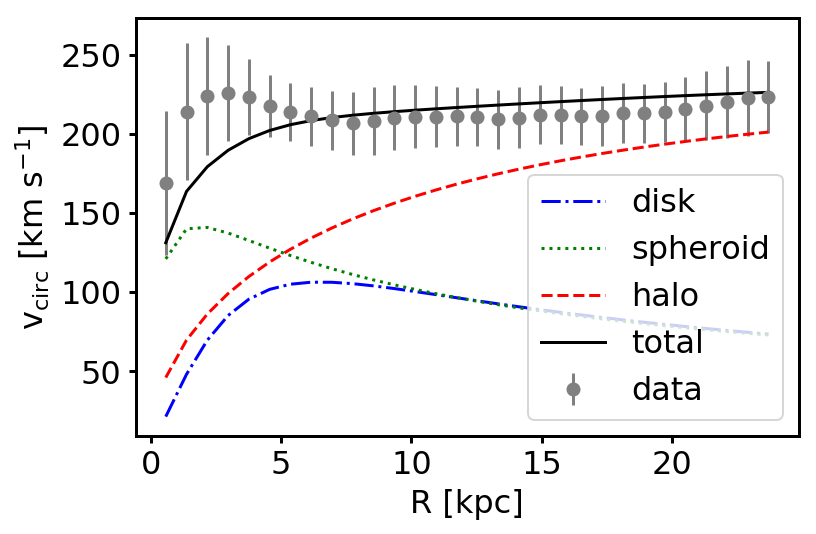

In [93]:
use_physical = False
fig,ax = plt.subplots()
ax.errorbar(R_bins_data, v_mean_data, yerr = v_std_data, fmt = 'o', color = 'grey', label = 'data')
ax.plot(R_bins_data, vcirc_MND,'b-.', label = 'disk')
ax.plot(R_bins_data, vcirc_HB, 'g:', label = 'spheroid')
ax.plot(R_bins_data, vcirc_NFW, 'r--', label = 'halo')
ax.plot(R_bins_data, vcirc_tot, color = 'black',  label = 'total')
ax.set_xlabel('R [kpc]')
ax.set_ylabel('$\mathrm{v}_{\mathrm{circ}}$ [km s$^{-1}$]')
ax.legend()  
fig.tight_layout()
fig.savefig(plotdir + '/potential/best_fit_circular_velocity_via_formula_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
plt.show()


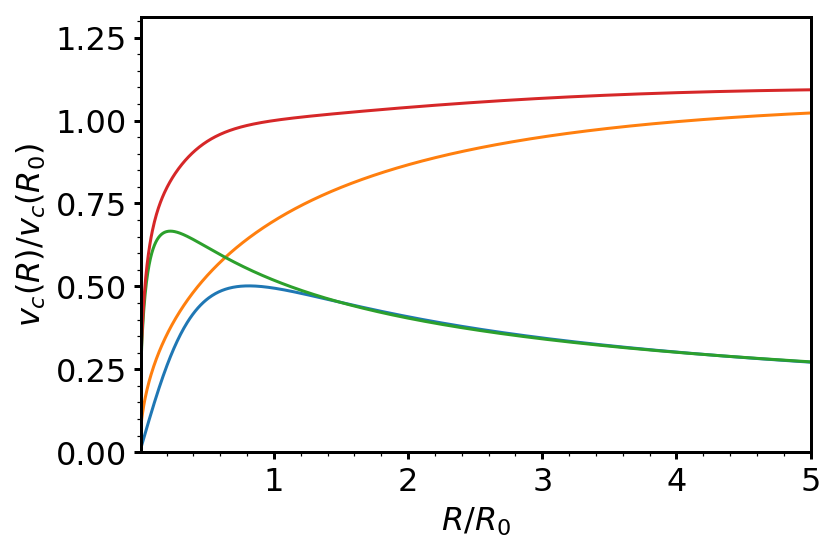

In [86]:
plotRotcurve(pot[0])
plotRotcurve(NFW, gcf = True)
plotRotcurve(pot[2], gcf = True)
plotRotcurve(pot, gcf = True)

In [46]:
print(v0_tot_kms)
print(np.sqrt(v0_HB_kms**2 + v0_MND_kms**2 + v0_NFWH_kms**2))

212.34825827
212.34825827


In [51]:
print(v0_HB_kms)

110.113021712
